# Testing top two models on unseen data

In [101]:
import pickle
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import os
os.chdir('/Users/beth/Documents/Metis/metis_project_3_files/clinical_trials/')

In [105]:
with open('X_test_scaled.pickle','rb') as read_file:
    X_test_scaled = pickle.load(read_file)
with open('y_test.pickle','rb') as read_file:
    y_test = pickle.load(read_file)
with open('X_test.pickle','rb') as read_file:
    X_test = pickle.load(read_file)

Some issues with scikitlearn versions - need to fix, XGBoost needs 23 but the ADASYN imputer I used needs 22. I need to figure this out.

In [114]:
with open('final_model.pickle', 'rb') as read_file:
    final_model = pickle.load(read_file)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VotingClassifier from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [106]:
with open('logistic_regression.pickle', 'rb') as read_file:
    lr = pickle.load(read_file)
    
with open('gbm.pickle', 'rb') as read_file:
    gbm = pickle.load(read_file)
    
with open('knn.pickle', 'rb') as read_file:
    knn = pickle.load(read_file)
    
with open('svc.pickle', 'rb') as read_file:
    knn = pickle.load(read_file)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at 

## The XGBoost model

In [527]:
preds = gbm.predict(X_test) 

In [528]:
preds 

array([0.35798976, 0.1215131 , 0.08370043, ..., 0.22671296, 0.12680238,
       0.2627288 ], dtype=float32)

The best cutoff for GBM was 0.2, based on a plot of F1 vs threshold in training

In [529]:
preds_bool = preds > 0.2

In [530]:
y_test_01 = []
for i in y_test:
    if i == 'Completed':
        y_test_01.append(False)
    else:
        y_test_01.append(True)

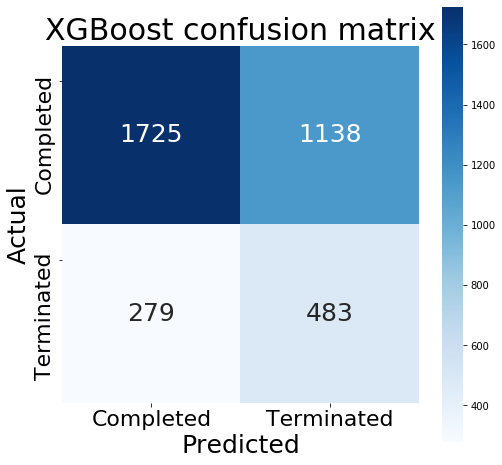

In [558]:
plt.figure(figsize=(8,8))
confusion = confusion_matrix(y_test_01, preds_bool)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f',
           annot_kws={'size':25})
plt.xticks(fontsize=22)
plt.yticks(fontsize=22,ticks=[0.2,1.2])

plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Actual',fontsize=25)
plt.title('XGBoost confusion matrix',fontsize=30);

plt.savefig('XGBoost_heatmap.jpg')

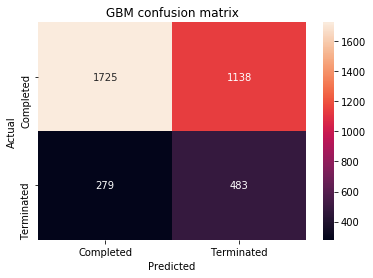

In [111]:
confusion = confusion_matrix(y_test_01, preds_bool)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GBM confusion matrix'); 

In [112]:
print(classification_report(y_test_01, preds_bool))

              precision    recall  f1-score   support

       False       0.86      0.60      0.71      2863
        True       0.30      0.63      0.41       762

    accuracy                           0.61      3625
   macro avg       0.58      0.62      0.56      3625
weighted avg       0.74      0.61      0.65      3625



The model preformed as well on the test data as the training data, which is great, it wasn't too overfit which is a concern for XGBoost

## The Soft-Voting Logistic Regression and kNeighbors ensemble

In [10]:
preds = final_model.predict(X_test_scaled)

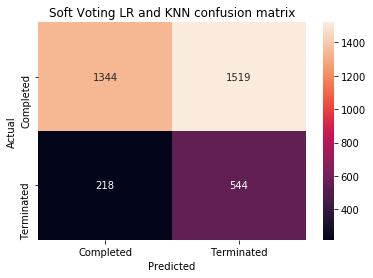

In [11]:
confusion = confusion_matrix(y_test, preds)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Soft Voting LR and KNN confusion matrix'); 

In [12]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

   Completed       0.86      0.47      0.61      2863
  Terminated       0.26      0.71      0.39       762

    accuracy                           0.52      3625
   macro avg       0.56      0.59      0.50      3625
weighted avg       0.73      0.52      0.56      3625



This model has a slightly lower F1-score but much higher recall than XGBoost, similar to on the validation set. This was the main benefit of this model - it had very high recall without reducing percision as much as other models, resulting in a fairly similar f1-score to models lower recall.

# ROC curves for some models

In [115]:
fpr, tpr, thresholds = roc_curve(y_test, final_model.predict_proba(X_test_scaled)[:,1], pos_label="Terminated")

In [116]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, lr.predict_proba(X_test_scaled)[:,1], pos_label='Terminated')

In [117]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:,1], pos_label='Terminated')

SVC in scikitlearn 22 doesn't have predict_proba

In [16]:
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, svc.predict_proba(X_test_scaled)[:,1], pos_label='Terminated')

AttributeError: 'SVC' object has no attribute 'probA_'

In [17]:
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, nb.predict_proba(X_test_scaled)[:,1], pos_label='Terminated')

In [118]:
final_auc = roc_auc_score(y_test, final_model.predict_proba(X_test_scaled)[:,1])

In [119]:
lrr_auc = roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1])

In [120]:
knn_auc = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:,1])

In [126]:
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(y_test, gbm.predict(X_test), pos_label='Terminated')

In [127]:
gbm_auc = roc_auc_score(y_test, gbm.predict(X_test))

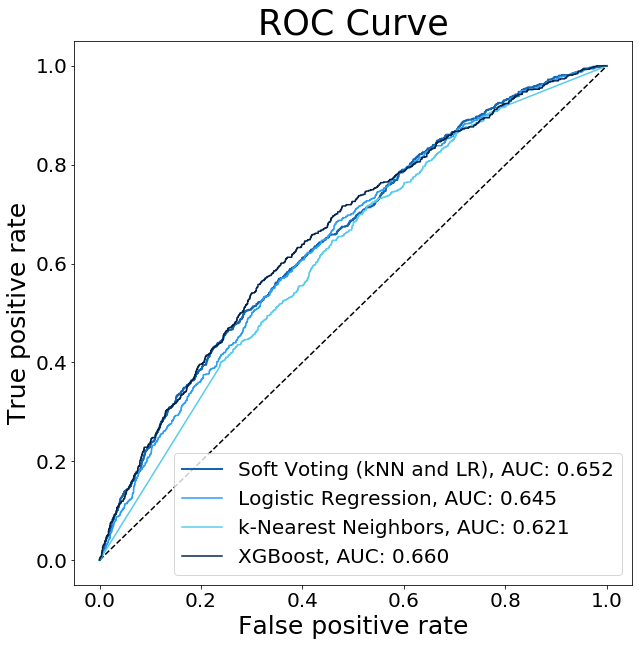

In [564]:
plt.figure(figsize=(10,10))

a = plt.plot(fpr,tpr,lw=2, c='#1167b1', label = 'Soft Voting (kNN and LR), AUC: {:.3f}'.format(final_auc))
plt.plot([0,1],[0,1],c='black',ls='--')
b = plt.plot(fpr_lr, tpr_lr, c='#2a9df4', label = 'Logistic Regression, AUC: {:.3f}'.format(lrr_auc))
c = plt.plot(fpr_knn, tpr_knn, c='#58CCED', label = 'k-Nearest Neighbors, AUC: {:.3f}'.format(knn_auc))
d = plt.plot(fpr_gbm, tpr_gbm, c='#03254c', label = 'XGBoost, AUC: {:.3f}'.format(gbm_auc))


plt.legend(loc='lower right', fontsize=20)
                                  
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate',fontsize=25)
plt.ylabel('True positive rate',fontsize=25)
plt.title('ROC Curve', fontsize=35);

plt.savefig('ROC.jpg')

# Histograms of classifications vs predictions from the GBM and LR models

I graphed the actual Completed and actual Terminited class histograms vs. the predicted probability of that class being terminated from the XGBoost model.

In [155]:
preds_term = preds[np.array(y_test_01) == True]

In [157]:
preds_comp = preds[np.array(y_test_01) == False]

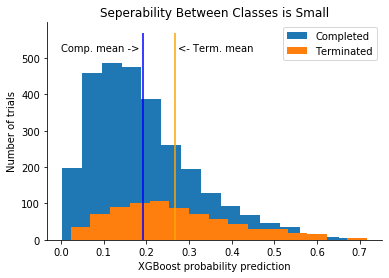

In [199]:
plt.hist(preds_comp, bins=15, label='Completed')
plt.hist(preds_term, bins=15, label='Terminated')
plt.vlines(0.266,0,570, color='orange')
plt.vlines(0.193,0,570, color='blue')
plt.text(0,520,'Comp. mean ->')
plt.text(0.275,520,'<- Term. mean')
plt.xlabel('XGBoost probability prediction')
plt.ylabel('Number of trials')
plt.legend(loc='best')
plt.title('Seperability Between Classes is Small')
sns.despine()

In [163]:
preds_term.mean()

0.2664283

In [164]:
preds_comp.mean()

0.19264373

There is poor seperability between the classes even with my best model!

Next I look at the seperability for just logistic regression - logistic regression will be the model I implement for my app. It is the fastest for preditions (kNN is way too slow to use the ensembl model). Also, it updates for every small change in values, whereas XGBoost only changes sporadically and less predictably. Logistic Regression will help give app uses an idea of the direction and stength of correlations of the features with the 'Terminated' outcome. 

In [416]:
preds = lr.predict_proba(X_test_scaled)[:,1]

In [417]:
preds_term = preds[np.array(y_test) == 'Terminated']

In [418]:
len(preds_term)

762

In [419]:
preds_comp = preds[np.array(y_test) == 'Completed']

In [420]:
len(preds_comp)

2863

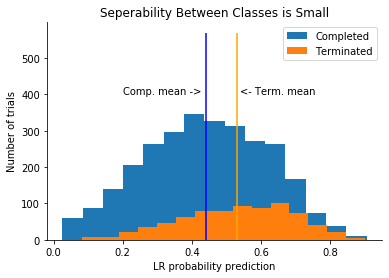

In [241]:
plt.hist(preds_comp, bins=15, label='Completed')
plt.hist(preds_term, bins=15, label='Terminated')
plt.vlines(preds_term.mean(),0,570, color='orange')
plt.vlines(preds_comp.mean(),0,570, color='blue')
plt.text(0.2,400,'Comp. mean ->')
plt.text(preds_term.mean() + .01,400,'<- Term. mean')
plt.xlabel('LR probability prediction')
plt.ylabel('Number of trials')
plt.legend(loc='best')
plt.title('Seperability Between Classes is Small')
sns.despine()

In [438]:
preds_term.mean()

0.5306437486150101

In [439]:
preds_comp.mean()

0.44081106515651874

## Trying to figure out a way to make my app's displayed percentage more accurate by incorporating the models error

I was next playing around with estimating what I called 'PPVs' for bins of Logistic Regression probability outputs. It would say what percent of cases in that bin are actually Terminated. I thought this might be a more accurate percent to display than the percent probability from Logistic Regression. This isn't really 'PPV', and I'm not sure what to call it

Currently the app displays the percent probability from Logistic Regression

In [440]:
term_count, term_thresh = np.histogram(preds_term, bins=1000)

In [441]:
comp_count, _ =  np.histogram(preds_comp, bins=term_thresh)

In [442]:
kde = gaussian_kde(preds_term)
term_smooth = kde.evaluate(term_thresh)

In [443]:
kde = gaussian_kde(preds_comp)
comp_smooth = kde.evaluate(term_thresh)

In [484]:
term_smooth[500]

1.976792950208228

In [485]:
comp_smooth[500]

1.9022686170598688

In [444]:
kde_PPV = term_smooth/(term_smooth + comp_smooth)

In [445]:
kde_PPV

array([0.16523417, 0.16667967, 0.16812505, ..., 0.70565245, 0.70596029,
       0.70627615])

In [446]:
test = pd.DataFrame({'Thresh':term_thresh,'PPV':kde_PPV})

In [430]:
test

,Thresh,PPV
0,0.081223,0.165234
1,0.082043,0.166680
2,0.082863,0.168125
3,0.083682,0.169570
4,0.084502,0.171014
...,...,...
996,0.897701,0.705061
997,0.898521,0.705353
998,0.899341,0.705652
999,0.900161,0.705960


In [447]:
term_thresh = list(term_thresh[::-1])+[0.0]

In [448]:
term_thresh[-1]

0.0

In [449]:
kde_PPV = list(kde_PPV[::-1])+[0.165]

In [450]:
kde_PPV[-1]

0.165

In [451]:
os.chdir('/Users/beth/Documents/Metis/metis_project_3/metis_project_3')

In [452]:
with open('PPV_threholds.pickle', 'wb') as write_file:
    pickle.dump(term_thresh, write_file)

In [462]:
with open('PPV.pickle', 'wb') as write_file:
    pickle.dump(kde_PPV, write_file)

In [455]:
average = X_test_scaled.mean(axis=0)

In [458]:
lr.predict_proba(average.reshape(1,-1))

array([[0.55036893, 0.44963107]])

In [464]:
for i, v in enumerate(term_thresh):
    if 0.449 > v:
        corrected_pred = kde_PPV[i]
        print(corrected_pred)
        break

0.475051277554616


In [471]:
test.iloc[450]

Thresh    0.450114
PPV       0.476264
Name: 450, dtype: float64

## Making a tSNE plot of the training data to show high mixing between classes in multidimensional space

In [486]:
from sklearn.manifold import MDS, TSNE

In [491]:
with open('X_train_scaled.pickle','rb') as read_file:
    X_train_scaled = pickle.load(read_file)

In [493]:
tsne=TSNE()
tsne_xtrain = tsne.fit_transform(X_train_scaled)

In [499]:
blue_colors = sns.color_palette("PuBu", 2)

In [497]:
with open('y_train.pickle','rb') as read_file:
    y_train = pickle.load(read_file)

In [523]:
y_train = y_train.rename('Overall Status')

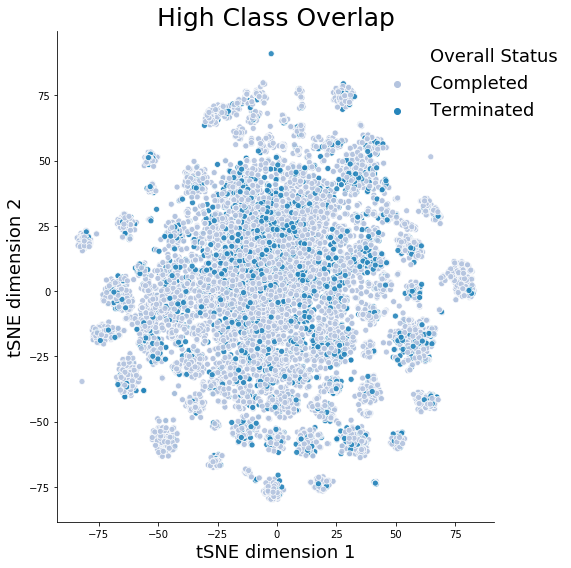

In [526]:
plt.figure(figsize=(8,8))
plt.title('High Class Overlap', fontsize=25)

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=y_train, alpha=0.9, palette=blue_colors )
plt.xlabel('tSNE dimension 1',fontsize=18)
plt.ylabel('tSNE dimension 2',fontsize=18)
plt.legend(bbox_to_anchor=(0.7, 1), loc='upper left',fontsize=18,frameon=False,title=False);
sns.despine()
plt.tight_layout()
plt.savefig('tSNE_train.jpg')